In [32]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import cv2
import glob
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("rainbow")
sns.set_style('whitegrid')

In [2]:
PATH = 'C:/Users/JChaotogo/Documents/DataSets/drugstocolab'
allpillspath = 'C:/Users/JChaotogo/Downloads/allpills'

In [52]:
df = pd.read_csv('C:/Users/JChaotogo/Desktop/pillinfo.csv')
df.head()
df.to_csv('C:/Users/JChaotogo/Desktop/pillinfo.csv')

In [53]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,NDC9,author,SPLCOLOR,SPLSHAPE,SPLSIZE,SPLSCORE,DEA_SCHEDULE_CODE,INGREDIENTS,RXCUI,RXTTY,RXSTRING,image_id,IMAGE_SOURCE,HAS_IMAGE
0,0,0,0,0,0,50,508440175,"L.N.K. International, Inc.",C48325,C48345,17.0,1,NaN,ACETAMINOPHEN[ACETAMINOPHEN],198440.0,SCD,Acetaminophen 500 MG Oral Tablet,50844-0175-10_NLMIMAGE10_5135A8AD,NLMIMAGE10,1
1,1,1,2,2,3,71,7811034,Sandoz Inc,C48327,C48348,8.0,1,NaN,TRIFLUOPERAZINE HYDROCHLORIDE[TRIFLUOPERAZINE],198325.0,SCD,Trifluoperazine 5 MG Oral Tablet,007811034,VA2,1
2,2,2,3,3,4,79,597620145,Greenstone LLC,C48326,C48336,18.0,1,NaN,PIROXICAM[PIROXICAM],198108.0,SCD,Piroxicam 20 MG Oral Capsule,59762-0145-01_NLMIMAGE10_333E99F4,RXIMAGE30,1
3,3,3,4,4,5,87,604290622,"Golden State Medical Supply, Inc.",C48325,C48348,9.0,1,NaN,OLANZAPINE[OLANZAPINE],312079.0,SCD,olanzapine 7.5 MG Oral Tablet,604290622,VA2,1
4,4,4,6,6,7,94,1433126,West-ward Pharmaceutical Corp,C48333,C48336,15.0,1,NaN,DICYCLOMINE HYDROCHLORIDE[DICYCLOMINE],991061.0,SCD,Dicyclomine Hydrochloride 10 MG Oral Capsule,001433126,Pillbox_dev,1


In [76]:
#Lets take the images from the top 3 shapes to classify
shapes = ['C48348', 'C48345', 'C48336']
for item in shapes:
    temp = df[df.SPLSHAPE==item]

    for imid in temp.image_id:
        suffix = '.jpg'
        imid = str(imid)
        path = os.path.join(allpillspath, imid + suffix)
        img = cv2.imread(path)              
        outpath = os.path.join(PATH, f'{item}', imid + suffix)
        cv2.imwrite(outpath, img)

In [78]:
#3 common shapes are round, oblong and capsules
roundpillsdir = os.path.join(PATH, 'round')
oblongpillsdir= os.path.join(PATH, 'oblong')
capsulesdir = os.path.join(PATH, 'capsules')

traindata = []
for img in os.listdir(roundpillsdir):
    traindata.append((os.path.join(roundpillsdir, img), 0))
for img in os.listdir(oblongpillsdir):
    traindata.append((os.path.join(oblongpillsdir,img), 1))
for img in os.listdir(capsulesdir):
    traindata.append((os.path.join(capsulesdir, img), 2))
    
traindata = pd.DataFrame(traindata, columns = ['image', 'label'], index=None)
traindata = traindata.sample(frac=1.).reset_index(drop=True)
traindata.head()

,image,label
0,C:/Users/JChaotogo/Documents/DataSets/drugstoc...,0
1,C:/Users/JChaotogo/Documents/DataSets/drugstoc...,1
2,C:/Users/JChaotogo/Documents/DataSets/drugstoc...,0
3,C:/Users/JChaotogo/Documents/DataSets/drugstoc...,0
4,C:/Users/JChaotogo/Documents/DataSets/drugstoc...,1


0    3637
1    2268
2    1373
Name: label, dtype: int64


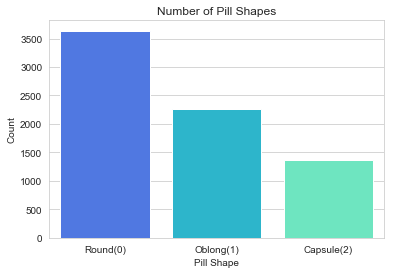

In [61]:
shapes_count = traindata.label.value_counts()
print(shapes_count)

sns.barplot(x=shapes_count.index, y=shapes_count.values)
plt.title('Number of Pill Shapes')
plt.xlabel('Pill Shape')
plt.ylabel('Count')
plt.xticks(range(len(shapes_count.index)), ['Round(0)', 'Oblong(1)', 'Capsule(2)'])
plt.show()

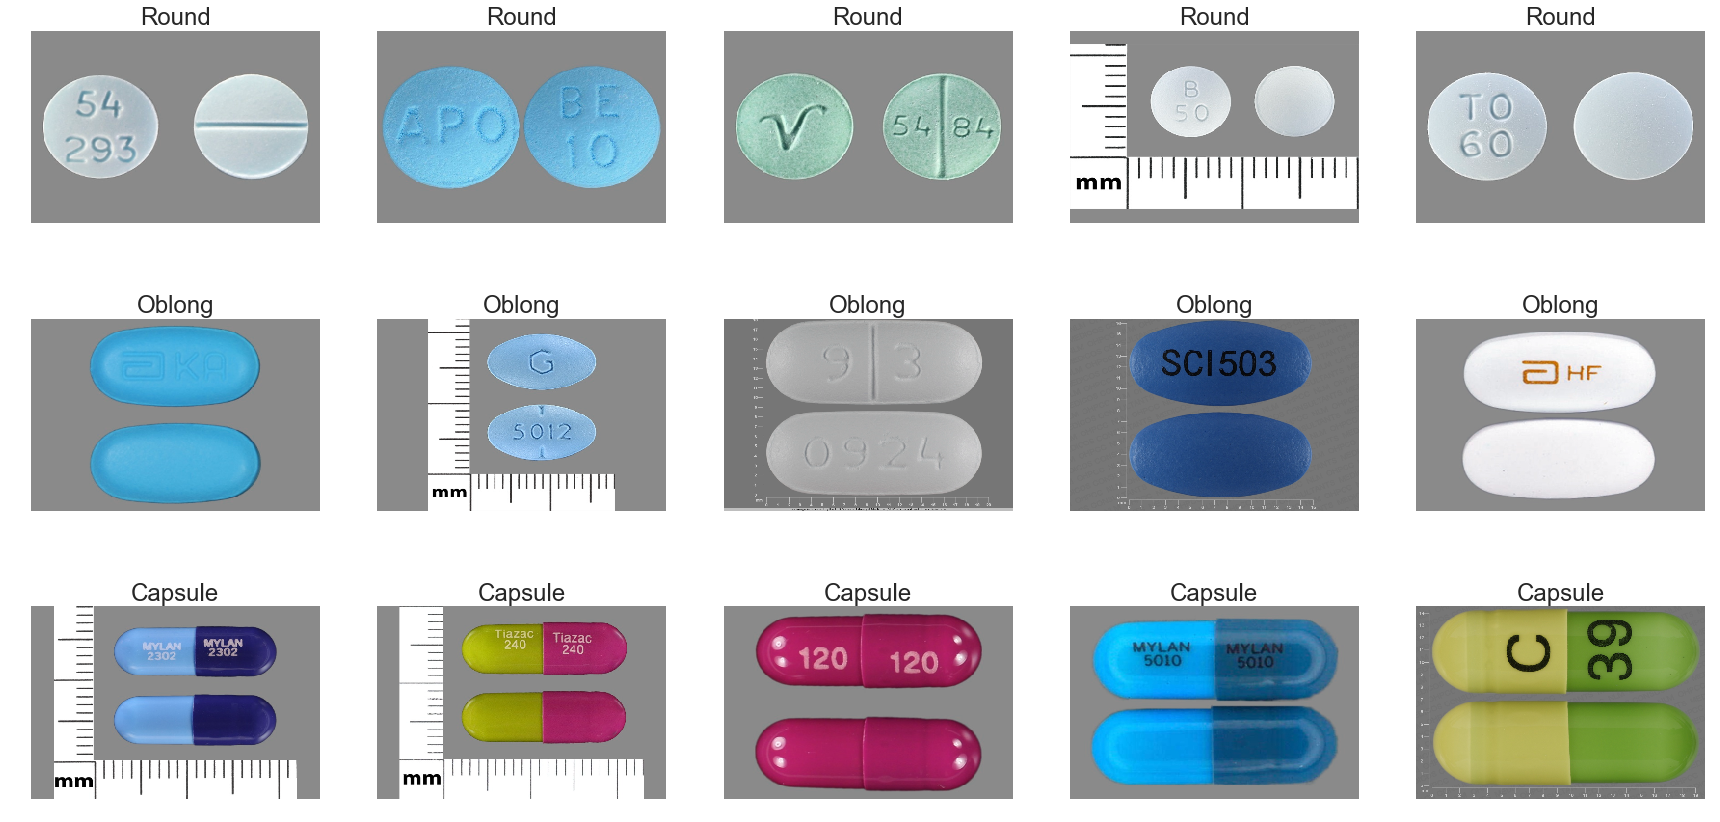

In [102]:
plt.figure(figsize = (30, 15))
for i in range(15):
    plt.subplot(3,5,i+1)
    if i < 5:
        img = cv2.imread(traindata[traindata.label==0].reset_index()['image'][i])
        img = cv2.resize(img, (300,200))
        plt.imshow(img)
        plt.title('Round', fontsize=24)
    elif i < 10:
        img = cv2.imread(traindata[traindata.label==1].reset_index()['image'][i])
        img = cv2.resize(img, (300,200))
        plt.imshow(img)
        plt.title('Oblong', fontsize=24)
    else:
        img = cv2.imread(traindata[traindata.label==2].reset_index()['image'][i+1])
        img = cv2.resize(img, (300,200))
        plt.imshow(img)
        plt.title('Capsule', fontsize=24)
    plt.axis('off')
    
plt.show()

#Some of the images appear to be corrupted so I'm going to remove them.
for index, img in enumerate(traindata.image):
    try:
        img = cv2.imread(img)
        traindata['height'], traindata['width'] = img.shape[0:2]
    except Exception:
        print(index)
        traindata.drop(index, inplace=True)

In [67]:
import shutil
for image in os.listdir('C:/Users/JChaotogo/Documents/DataSets/drugstocolab/capsules'):
    path = os.path.join('C:/Users/JChaotogo/Documents/DataSets/drugstocolab/capsules', image)
    try:
        img = Image.open(path)
        img.verify()
        img1 = cv2.imread(path)
        img.close()
    except Exception as e:
        print(e)
        shutil.move(path, 'C:/Users/JChaotogo/Documents/DataSets/drugstocolab')

In [96]:
try:
    traindata['width'], traindata['height'] = traindata.image.apply(lambda x: Image.open(x).size)
except Exception as e:
    pass

In [103]:
for index, image in enumerate(traindata.image):
    try:
        traindata['width'], traindata['height'] = Image.open(image).size
    except Exception as e:
        print (e)
        print(index)

In [104]:
traindata.head()

,image,label,width,height
0,C:/Users/JChaotogo/Documents/DataSets/drugstoc...,0,1024,768
1,C:/Users/JChaotogo/Documents/DataSets/drugstoc...,1,1024,768
2,C:/Users/JChaotogo/Documents/DataSets/drugstoc...,0,1024,768
3,C:/Users/JChaotogo/Documents/DataSets/drugstoc...,0,1024,768
4,C:/Users/JChaotogo/Documents/DataSets/drugstoc...,1,1024,768


(array([   0.,    0.,    0.,    0.,    0., 7499.,    0.,    0.,    0.,
           0.]),
 array([1023.5, 1023.6, 1023.7, 1023.8, 1023.9, 1024. , 1024.1, 1024.2,
        1024.3, 1024.4, 1024.5]),
 <a list of 10 Patch objects>)

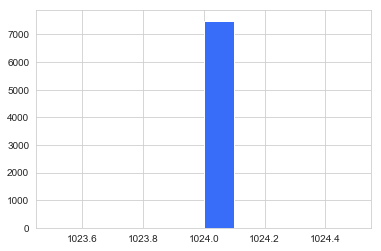

In [111]:
plt.hist(traindata.width)